## Take a time seres from a specifed location using the yeoda modole and test the disturbance magnitude and time code

In [19]:
import os, osr, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
#
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import my aux functions
from auxilary_ts_tools_mm import features_from_yeodaTS, plot_TS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Specify the folder with a S1 datacube (a 300x300 m<sup>2</sup> Equi7Tile)

In [2]:
tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
tile_dir2_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N066T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field']
filepaths1 = glob.glob(os.path.join(tile_dir1_path,'*.tif'))
filepaths2 = glob.glob(os.path.join(tile_dir2_path,'*.tif'))

Read the datacube:

In [3]:
sig0_dc1 = SIG0DataCube(filepaths=filepaths1, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
sig0_dc2 = SIG0DataCube(filepaths=filepaths2, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc1.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,var_name,tile_name
0,2019-09-24 09:22:59,VH,D039,S1AIWGRDH,SIG0,E078N066T3
1,2020-11-18 09:14:33,VH,D141,S1B,SIG0,E078N066T3
2,2020-06-21 09:15:13,VV,D141,S1A,SIG0,E078N066T3
3,2019-02-03 09:14:37,VV,D141,S1AIWGRDH,SIG0,E078N066T3
4,2019-02-08 09:23:15,VH,D039,S1AIWGRDH,SIG0,E078N066T3


Filter by date:

In [4]:
toi_start, toi_end = datetime(2017, 1, 1), datetime(2021, 1, 1)
sig0_dc1 = sig0_dc1.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)
sig0_dc2 = sig0_dc2.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)

Select bands:

In [5]:
sig0_vv_dc1 = sig0_dc1.filter_by_dimension('VV', name='band')
sig0_vh_dc1 = sig0_dc1.filter_by_dimension('VH', name='band')
#
sig0_vv_dc2 = sig0_dc2.filter_by_dimension('VV', name='band')
sig0_vh_dc2 = sig0_dc2.filter_by_dimension('VH', name='band')

Merge and sort the datacubes:

In [6]:
sig0_vv_dc = sig0_vv_dc1.unite(sig0_vv_dc2)
sig0_vv_dc = sig0_vv_dc.sort_by_dimension('time', ascending=True)
#
sig0_vh_dc = sig0_vh_dc1.unite(sig0_vh_dc2)
sig0_vh_dc = sig0_vh_dc.sort_by_dimension('time', ascending=True)
#
sig0_vv_dc.inventory

,filepath,time,band,extra_field,sensor_field,var_name,tile_name
732,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:07,VV,D039,S1AIWGRDH,SIG0,E078N066T3
452,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:32,VV,D039,S1AIWGRDH,SIG0,E078N066T3
537,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:57,VV,D039,S1AIWGRDH,SIG0,E078N066T3
630,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:13:54,VV,D141,S1AIWGRDH,SIG0,E078N066T3
782,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:14:19,VV,D141,S1AIWGRDH,SIG0,E078N066T3
...,...,...,...,...,...,...,...
31,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-23 09:23:29,VV,D039,S1A,SIG0,E078N066T3
87,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-29 09:22:39,VV,D039,S1B,SIG0,E078N066T3
319,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:26,VV,D141,S1A,SIG0,E078N066T3
222,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:51,VV,D141,S1A,SIG0,E078N066T3


Get a time series for a point of interest:

In [7]:
poi = (-3.48472, -54.82820)
sref = osr.SpatialReference()
sref.ImportFromEPSG(4326)
#
sig0_vv_ts = sig0_vv_dc.load_by_coords(*poi, sref=sref, dtype='dataframe')
sig0_vh_ts = sig0_vh_dc.load_by_coords(*poi, sref=sref, dtype='dataframe')

Remane the variable and drop na as well as indexing:

<AxesSubplot:xlabel='time'>

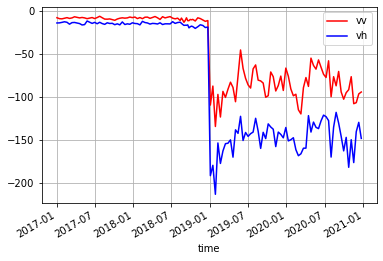

In [8]:
sig0_vv_ts = sig0_vv_ts.dropna().droplevel(['x', 'y']).rename(columns={'1' : 'vv'})
sig0_vh_ts = sig0_vh_ts.dropna().droplevel(['x', 'y']).rename(columns={'1' : 'vh'})
# plot:
my_xticks = pd.date_range(datetime(2017,1,1), datetime(2021,1,1), freq='YS')
ax2 = sig0_vv_ts.plot(style='r-', grid=True)
sig0_vh_ts.plot(style='b-', grid=True, ax=ax2)

Rescale the data in 2019 and 2020

<AxesSubplot:xlabel='Time', ylabel='Bacscatter Intensity [dB]'>

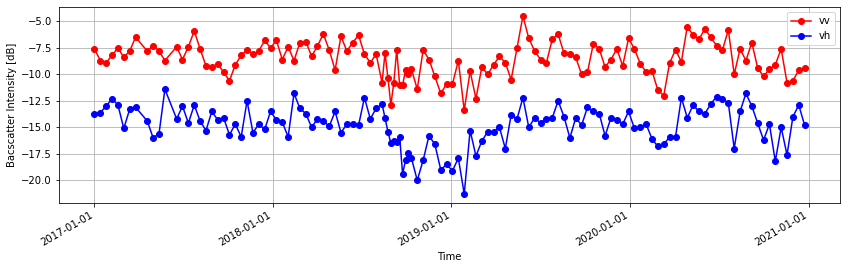

In [9]:
sig0_vv_ts.loc['2019-1-1':'2021-1-1'] = sig0_vv_ts.loc['2019-1-1':'2021-1-1'].div(10.).round(1)
sig0_vh_ts.loc['2019-1-1':'2021-1-1'] = sig0_vh_ts.loc['2019-1-1':'2021-1-1'].div(10.).round(1)
# plot to check:
my_xticks = pd.date_range(datetime(2017,1,1), datetime(2021,1,1), freq='YS')
ax1 = sig0_vv_ts.plot(style='ro-', xticks=my_xticks, grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')
sig0_vh_ts.plot(style='bo-', ax=ax1, xticks=my_xticks, grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')

See the difference in time to decde on the minum sample interval:

In [10]:
np.unique(sig0_vh_ts.index.round('D').to_series().diff().values.astype('timedelta64[D]'))

array([    6,    12,    24, 'NaT'], dtype='timedelta64[D]')

Round the time and resample to 6 day TS:

In [11]:
sig0_vh_ts.index = sig0_vh_ts.index.round('D')
#
sig0_vh_ts_6d = sig0_vh_ts.resample('6D').interpolate(method='linear')

<AxesSubplot:xlabel='Time', ylabel='Bacscatter Intensity [dB]'>

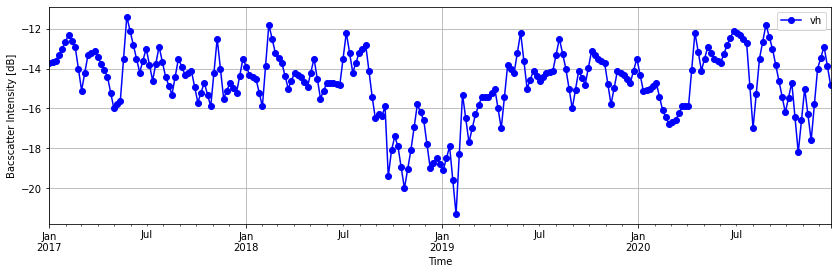

In [12]:
sig0_vh_ts_6d.plot(style='bo-',grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')

Plot and get the time seres features:

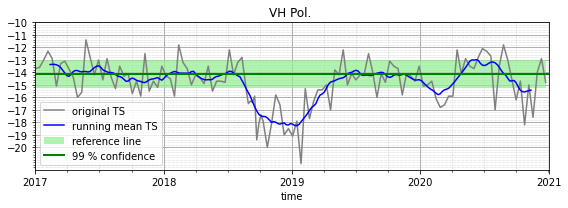

In [51]:
plot_TS(sig0_vh_ts_6d)
#
myFeatures = features_from_yeodaTS(sig0_vh_ts_6d)

In [52]:
myFeatures

[0,
 -14.127469135802468,
 1.111462689380991,
 3,
 1,
 1,
 array([1.29253086]),
 0,
 39.0,
 array([4.14253086]),
 numpy.datetime64('2019-01-15T00:00:00.000000000'),
 -144,
 -696,
 -552,
 array([7.17253086]),
 numpy.datetime64('2019-01-27T00:00:00.000000000'),
 12,
 10.0]